# 분류

### MNIST

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['details', 'frame', 'url', 'feature_names', 'DESCR', 'target', 'target_names', 'categories', 'data'])

- data : 행은 샘플, 열은 특성으로 구성된 배열
- target : data에 대한 레이블 배열
- DESCR : 데이터셋에 대한 설명

In [3]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
y[0]

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진분류기(binary classifier)

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
(sum(y_train_5) + sum(y_test_5)) / (len(y_train) + len(y_test)) *100
# 약 9%가 class=5

9.018571428571429

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=44)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=44, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

### 성능 측정
#### 교차 검증을 사용한 정확도 측정

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=44) # 클래스별 비율이 동일하도록 계층적 샘플링으로 폴드를 만듦. n_splits=몇개로 분할할것인지.

# cross_val_score() 구현
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(len(train_index), len(test_index))
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

40000 20000
0.95325
40000 20000
0.96725
40000 20000
0.964


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds, scoring="accuracy")

array([0.95325, 0.96725, 0.964  ])

-> 5인지 아닌지를 분류하는 이진분류기의 정확도가 95%를 넘는다.

- 분류에서, 특히 클래스가 몰려있을 경우 Stratified K-fold cross-validation 사용한다고. 
- 위 방법처럼 폴드를 만들고 cross_val_score()에 cv옵션으로 건네주면 폴드에 대한 세부튜닝이 가능함.
- [참고](https://homeproject.tistory.com/m/6)

단, 불균형 데이터셋에 대한 성능지표를 '정확도'로 설정할 때 문제가 있음.

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool) # 모든 예측값을 0, False, 즉 5가 아니라고 예측.

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

-> 불균형한 데이터셋임에도 불구하고 정확도를 성능지표로 설정했기 때문에 모든 데이터 샘플에 대하여 5가 아니라고 예측해도 정확도가 90% 이상.

#### 오차 행렬(confusion matrix)

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred  = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53570,  1009],
       [ 1301,  4120]], dtype=int64)

- 행 : 실제 클래스, 열 : 예측 클래스

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### 정밀도와 재현율 + trade-off

- 정밀도(precision) = TP / (TP + FP) : 모델이 True라고 예측한 것 중에서 실제 True인 것의 비율
- 재현율(recall) = TP / (TP + FN) : 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율
    + = 민감도(sensitivity) = TPR(true positive rate)

In [20]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8032754922986937
0.7600073787124146


- 정밀도 : 5로 예측한 이미지 중 80%만 정확하다.
- 재현율 : 실제 5 중 76%만 감지했다.

F1 score
- 정밀도와 재현율의 조화평균

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7810426540284361

- 0 < f1 score < 1
- f1 score에서 정밀도와 재현율이 비슷할수록 f1 score가 높다.
- 그러나 항상 비슷한 것이 좋은 것은 아님.
- FN(실제가 양성일 때, 음성으로 예측한 경우)와 FP(실제가 음성일 때, 양성으로 예측한 경우)의 중요도를 비교 후
- FN이 낮아야 한다면 높은 재현율이 중요하고, FP가 낮아야한다면 높은 정밀도가 중요하다.
- F score의 일반화된 조화 평균식에서 정밀도와 재현율 중요성에 따라 파라미터를 조절

정밀도와 재현율의 트레이드오프 관계를 더 살펴보자면

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method="decision_function", cv=3)

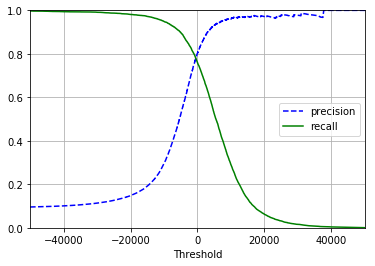

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend(loc="center right") 
    plt.xlabel("Threshold")     
    plt.grid(True)                          
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

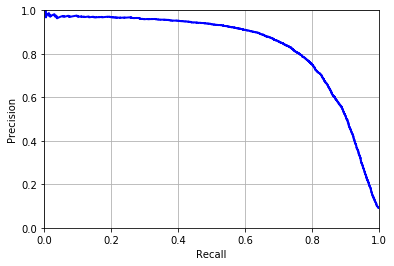

In [24]:
# PR곡선
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)] #precisions>=0.9의 값은 0또는 1이므로 가장 맨 앞에 있는 인덱스가 argmax의 값으로 리턴된다.
threshold_90_precision

3049.7202630278925

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000263782643102

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.6294041689725143

#### ROC 곡선
- receiver operating characteristic
- ROC = TPR(재현율) / FPR = (TP/(TP+FN)) / (FP/(FP+TN))

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

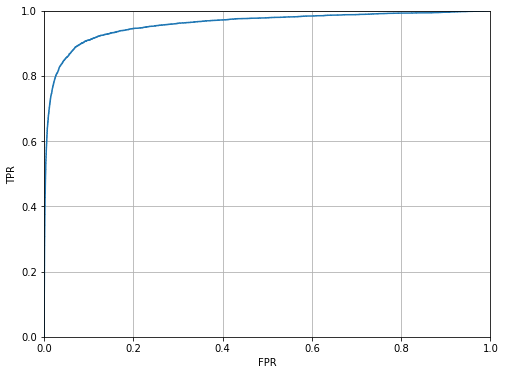

In [30]:
def plot_roc_curve(fpr, tpr, label=None) :
    plt.plot(fpr, tpr, label=label)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid()
    plt.axis([0,1,0,1])

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, "SGD")
plt.show()

- AUC(area under the curve)가 1에 가까울수록 분류를 잘한다고 볼 수 있다. (0.5 ~ 1)

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9589703559022139

양성 클래스가 드물거나 거짓음성보다 거짓양성이 중요할 때  -> PR곡선, 그렇지 않으면 ROC곡선 사용.

In [32]:
# randomforest와 sgd비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=44)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") #predict_proba : 클래스에 속할 확률배열을 return
y_probas_forest

array([[0.1 , 0.9 ],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.02, 0.98],
       [0.96, 0.04],
       [0.95, 0.05]])

In [33]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

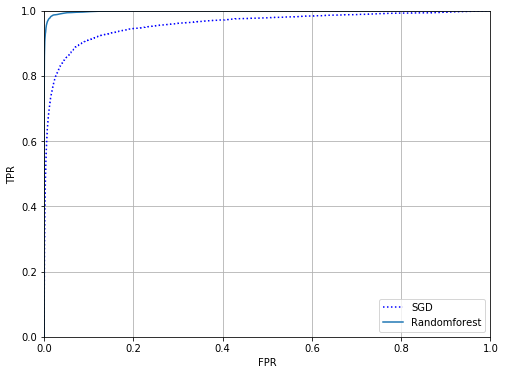

In [34]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Randomforest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983833658711379

In [36]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9897080445284604

In [37]:
recall_score(y_train_5, y_train_pred_forest)

0.8692123224497326

## 다중분류

- OvR(one-versus-the-rest) 또는 OvA(one-versus-all) : 분류 결과 결정 점수가 가장 높은 것을 클래스로 선택하는 것.
    + 대부분 OvR 선택.
- OvO(one-versus-one) : 두개의 클래스 조합마다 이진분류기를 훈련시켜 모든 분류기의 결과 중 가장 많은 양성으로 분류된 클래스로 선택하는 것. 클래스가 n개일 경우, 이진분류기는 총 nC2, n(n-1)/2
    + 장점은 각 분류기의 훈련에 두 클래스에 해당하는 샘플만을 필요로 한다는 것. 훈련데이터셋 크기에 민감한 SVM의 경우.

In [38]:
from sklearn.svm import SVC #ovo기반
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
svm_acc = cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

In [41]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_acc = cross_val_score(ovr_clf, X_train, y_train, cv=3, scoring="accuracy")

In [42]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_acc = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [43]:
from sklearn.ensemble import RandomForestClassifier
rnf_clf = RandomForestClassifier()
rnf_clf.fit(X_train, y_train)
rnf_acc = cross_val_score(rnf_clf, X_train, y_train, cv=3, scoring="accuracy")

In [44]:
svm_acc.mean(), ovr_acc.mean(), sgd_acc.mean(), rnf_acc.mean()

(0.9749, 0.9752000000000001, 0.8696, 0.96475)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scaled_acc = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
scaled_acc.mean()

0.8975166666666667

### 에러분석
- 성능이 좋은 모델 몇 개를 선정한 후 성능을 높이기 위해 에러의 종류를 분석해보자.

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5576,    0,   21,    6,    9,   47,   34,    6,  223,    1],
       [   0, 6404,   36,   24,    4,   44,    4,    7,  208,   11],
       [  28,   28, 5217,   94,   73,   26,   67,   39,  377,    9],
       [  21,   17,  116, 5232,    2,  209,   26,   40,  395,   73],
       [  10,   14,   40,   10, 5195,   12,   34,   25,  340,  162],
       [  26,   14,   29,  165,   55, 4468,   75,   16,  513,   60],
       [  29,   15,   40,    3,   42,   95, 5556,    5,  132,    1],
       [  19,   10,   51,   28,   49,   14,    3, 5694,  184,  213],
       [  16,   66,   47,   87,    3,  131,   25,   10, 5423,   43],
       [  25,   19,   30,   65,  119,   39,    1,  178,  368, 5105]],
      dtype=int64)

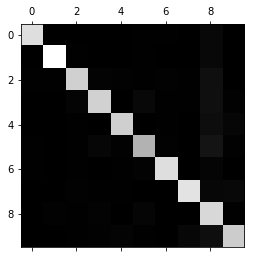

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 각 클래스의 개수가 동일하지 않기 때문에 개수로 밝기를 나타내는 문제
- 오류를 보고싶은거니까 대각선은 0으로.

In [48]:
# 비율로
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

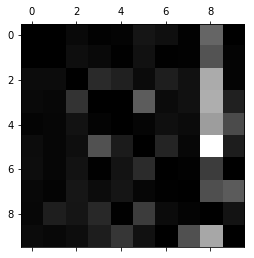

In [49]:
np.fill_diagonal(norm_conf_mx, 0) # 대각선은 0으로
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 8으로 잘못 분류됨. 
- 3과 5 분류를 잘 못함.

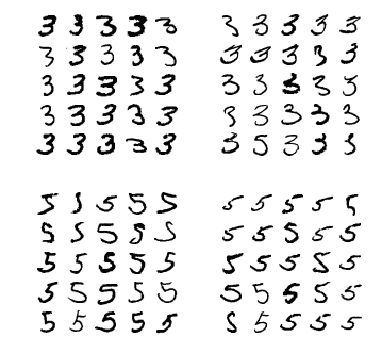

In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3,5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]
plt.figure(figsize=(6,6))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중 레이블 분류
- 여러개의 이진 레이블을 가질 경우

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [52]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [53]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 다중 레이블 분류에서 한 클래스의 개수가 많다면 그  레이블에 클래스의 지지도support로 가중치를 주어야 함. 즉 레이블에 속한 샘플 수를 가중치로. 
- average="weighted" 옵션으로 지지도를 가중치로 줄 수 있다.

## 다중 출력 분류(multioutput classification)
다중 레이블 분류 + 출력이 여러개

In [55]:
noise = np.random.randint(0,100, (len(X_train), 784))
noise.shape

(60000, 784)

In [56]:
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [57]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [58]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

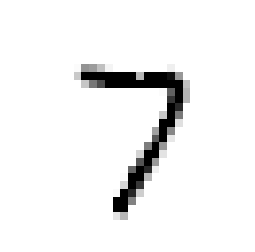

In [59]:
some_index=0
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

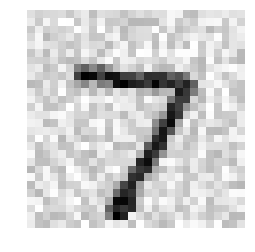

In [60]:
plot_digit(X_test_mod[some_index])

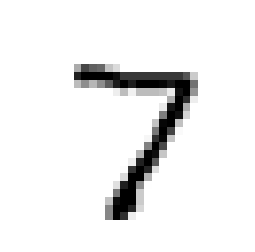

In [61]:
plot_digit(y_test_mod[some_index])

## 연습문제

1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성. KNeighborsClassifier 분류기 사용, 그리드 탐색(weight, n_neighbor)

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights' : ['uniform', 'distance'],
    'n_neighbors' : [3,4,5]
}]

knn_clf = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [69]:
import pandas as pd
pd.DataFrame(knn_grid.cv_results_).sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,38.039699,1666.161635,0.970350,1.000000,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",1,0.97090,1.000000,0.96980,1.000000,0.97035,1.000000,3.262936,60.438026,0.000449,0.000000
1,30.773214,1579.466765,0.969333,1.000000,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",2,0.97040,1.000000,0.96890,1.000000,0.96870,1.000000,1.169346,33.077789,0.000759,0.000000
5,35.874666,1583.214973,0.968600,1.000000,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",3,0.96880,1.000000,0.96795,1.000000,0.96905,1.000000,4.432816,11.965494,0.000471,0.000000
0,34.335126,1590.138454,0.968183,0.984842,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",4,0.96900,0.984675,0.96805,0.984650,0.96750,0.985200,4.817891,54.358590,0.000620,0.000254
4,35.514262,1610.058634,0.967417,0.979133,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",5,0.96760,0.979450,0.96710,0.978725,0.96755,0.979225,2.599715,46.959810,0.000225,0.000303
2,34.451751,1592.441538,0.966633,0.980375,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",6,0.96625,0.980425,0.96640,0.980075,0.96725,0.980625,2.616623,19.771090,0.000440,0.000227


In [66]:
knn_grid.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [71]:
knn_grid.best_score_

0.9703500000000002

In [78]:
knn_pred = knn_grid.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_pred)

0.9714

2. 데이터 증식 = 훈련 세트 확장(training set expansion)
    - MNIST 이미지를 상하좌우 한 픽셀씩 이동시키는 함수를 만들고,
    - 이동시킨 4개의 복사본을 훈련세트에 추가.
    - 1에서 찾은 모델로 훈련시킨 뒤 테스트 세트에서 정확도를 측정하고 성능이 높아졌는지 확인

In [73]:
from scipy.ndimage.interpolation import shift

In [101]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

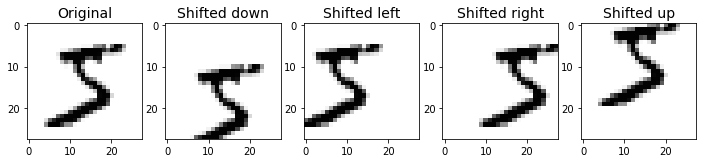

In [103]:
image = X_train[0]
shifted_image_left = shift_image(image, -5, 0)
shifted_image_right = shift_image(image, 5,0)
shifted_image_up = shift_image(image, 0,-5)
shifted_image_down = shift_image(image, 0, 5)

plt.figure(figsize=(12,3))
plt.subplot(151)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(152)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(153)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(154)
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(155)
plt.title("Shifted up", fontsize=14)
plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [104]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [105]:
X_train_augmented.shape, y_train_augmented.shape

((300000, 784), (300000,))

In [107]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [109]:
knn_clf = KNeighborsClassifier(**knn_grid.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [110]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

3. 타이타닉 데이터셋 - [링크](https://github.com/jsj267/Book-notes/blob/master/Hands-on%20machine%20learning%20with%20scikit-learn%202nd/3%EC%9E%A5_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C3_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89.ipynb)

4. 스팸 분류기 만들기 - [링크](https://github.com/jsj267/Book-notes/blob/master/Hands-on%20machine%20learning%20with%20scikit-learn%202nd/3%EC%9E%A5_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C4_%EC%8A%A4%ED%8C%B8%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb)